# Test different interaction targets

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.interpolate import interp1d
import copy
import pkg_resources
import glob
import os
from orsa.spectrum import OscillatedSpectrum

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.7.3


## Define some general variables

In [2]:
E_step = 0.001        # MeV
E_min = 0             # MeV
E_max = 50            # MeV
n_evts = 1e23         # Numero of supernova events (just a rough example)
scale_IBD = 1e25      # renormalization factor (We don't know the number of targets and their ratio)
T_min_e = 0.2         # MeV (minimum detectable kinetic energy for e-)
T_min_p = 0.2         # MeV (minimum detectable kinetic energy for p)

E = np.arange(E_min+E_step/2, E_max+E_step, E_step)

## Choose a color palette
(I defined colors similiar to the ones used in the JUNO supernova plot... change them)

In [3]:
blue = sns.color_palette('Blues_r', 6)
red = sns.color_palette('Reds_r', 4)

color = dict()
color[r'$\bar{\nu}_e-p$ (CC)'] = 'k'
color[r'$\nu_e-e$ (NC)'] = blue[0]
color[r'$\bar{\nu}_e-e$ (NC)'] = blue[1]
color[r'$\nu_{\mu/\tau}-e$ (NC)'] = blue[2]
color[r'$\bar{\nu}_{\mu/\tau}-e$ (NC)'] = blue[3]
color[r'$\bar{\nu}_e-^{12}C$ (CC)'] = 'pink'
color[r'$\nu_e-^{12}C$ (CC)'] = 'g'
color[r'$\nu_{e/\mu/\tau}-p$ (NC)'] = red[1]
color[r'$\bar{\nu}_{e/\mu/\tau}-p$ (NC)'] = red[0]

## Calculate the integrated cross sections

In [4]:
data = dict()
data[r'$\bar{\nu}_e-p$ (CC)'] = orsa.xs.sigma_IBD(Z=1, E_nu=E, Q=0.782347, logft=3.017, r=0.8783e-15, J_i=1/2, J_f=1/2, particle='nubar')
data[r'$\nu_e-e$ (NC)'] = orsa.xs.sigma_elastic(E_nu=E, T_min=T_min_e, particle='nu_e')
data[r'$\bar{\nu}_e-e$ (NC)'] = orsa.xs.sigma_elastic(E_nu=E, T_min=T_min_e, particle='nubar_e')
data[r'$\nu_{\mu/\tau}-e$ (NC)'] = orsa.xs.sigma_elastic(E_nu=E, T_min=T_min_e, particle='nu_mu')
data[r'$\bar{\nu}_{\mu/\tau}-e$ (NC)'] = orsa.xs.sigma_elastic(E_nu=E, T_min=T_min_e, particle='nubar_mu')
data[r'$\bar{\nu}_e-^{12}C$ (CC)'] = orsa.xs.sigma_IBD(Z=6, E_nu=E, Q=13.3694, logft=4.0617, r=2.4702e-15, J_i=0, J_f=1, particle='nubar')
data[r'$\nu_e-^{12}C$ (CC)'] = orsa.xs.sigma_IBD(Z=6, E_nu=E, Q=17.3381, logft=4.1106, r=2.4702e-15, J_i=0, J_f=1, particle='nu')
data[r'$\nu_{e/\mu/\tau}-p$ (NC)'] = orsa.xs.sigma_elastic_p(E_nu=E, T_min=T_min_p, particle='nu')
data[r'$\bar{\nu}_{e/\mu/\tau}-p$ (NC)'] = orsa.xs.sigma_elastic_p(E_nu=E, T_min=T_min_p, particle='nubar')

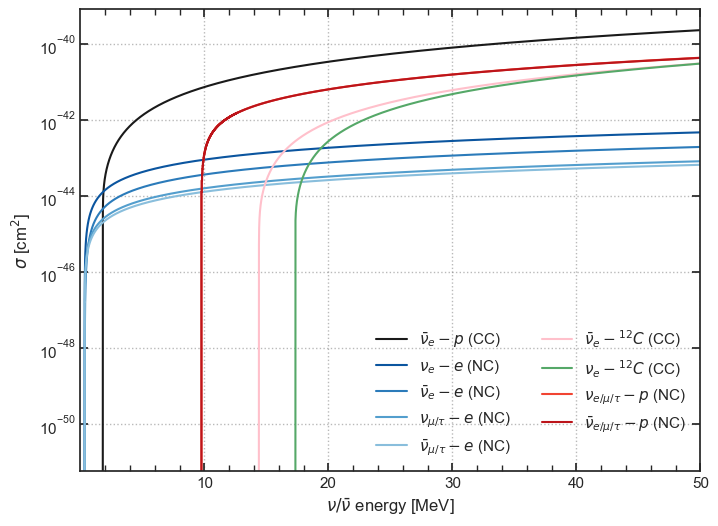

In [5]:
fig, ax = plt.subplots(figsize = (8,6))

ax.grid(ls = ':', c = 'k', alpha = 0.3)

for el in data:
    ax.plot(E, data[el], label = el, c = color[el])

ax.set_yscale('log')
ax.legend(ncols = 2, frameon = False)

ax.set_xlim(E.min(), E.max())

ax.set_xlabel(r'$\nu/\bar{\nu}$ energy [MeV]')
ax.set_ylabel(r'$\sigma$ [cm$^2$]');

## Build a fake supernova spectrum

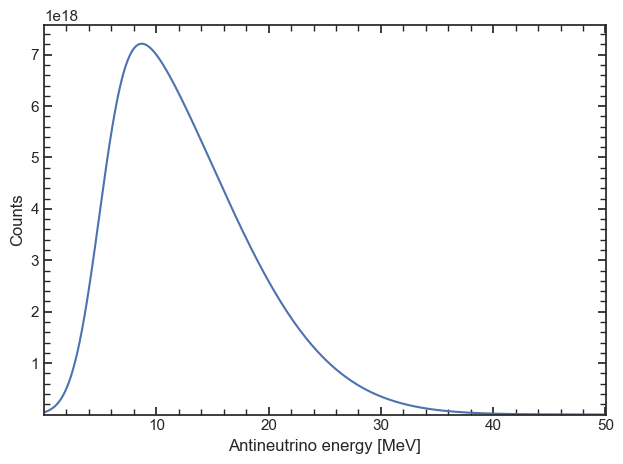

In [6]:
import scipy

sk = scipy.stats.skewnorm(a = 5, loc = 5, scale = 10)
spectrum = OscillatedSpectrum(E_centers=E, counts=sk.pdf(E), isPDF=False).norm(n_evts)
spectrum

## Calculate the differential cross sections and the recoil spectra

In [7]:
detector = orsa.detector.default()
data_rec = dict()

detector.target = orsa.detector.Target('p', 'IBD')
data_rec[r'$\bar{\nu}_e-p$ (CC)'] = scale_IBD*detector.to_dep(spectrum)

detector.target = orsa.detector.Target('e-', 'elastic', {'particle': 'nu_e'})
data_rec[r'$\nu_e-e$ (NC)'] = detector.to_dep(spectrum)

detector.target = orsa.detector.Target('e-', 'elastic', {'particle': 'nubar_e'})
data_rec[r'$\bar{\nu}_e-e$ (NC)'] = detector.to_dep(spectrum)

detector.target = orsa.detector.Target('e-', 'elastic', {'particle': 'nu_mu'})
data_rec[r'$\nu_{\mu/\tau}-e$ (NC)'] = detector.to_dep(spectrum)

detector.target = orsa.detector.Target('e-', 'elastic', {'particle': 'nubar_mu'})
data_rec[r'$\bar{\nu}_{\mu/\tau}-e$ (NC)'] = detector.to_dep(spectrum)

detector.target = orsa.detector.Target('C12', 'IBD', dict(Z=6, Q=13.3694, logft=4.0617, r=2.4702e-15, J_i=0, J_f=1, particle='nubar'))
data_rec[r'$\bar{\nu}_e-^{12}C$ (CC)'] = scale_IBD*detector.to_dep(spectrum)

detector.target = orsa.detector.Target('C12', 'IBD', dict(Z=6, Q=17.3381, logft=4.1106, r=2.4702e-15, J_i=0, J_f=1, particle='nu'))
data_rec[r'$\nu_e-^{12}C$ (CC)'] = scale_IBD*detector.to_dep(spectrum)

detector.target = orsa.detector.Target('p', 'elastic', {'particle': 'nu'})
data_rec[r'$\nu_{e/\mu/\tau}-p$ (NC)'] = detector.to_dep(spectrum)

detector.target = orsa.detector.Target('p', 'elastic', {'particle': 'nubar'})
data_rec[r'$\bar{\nu}_{e/\mu/\tau}-p$ (NC)'] = detector.to_dep(spectrum)


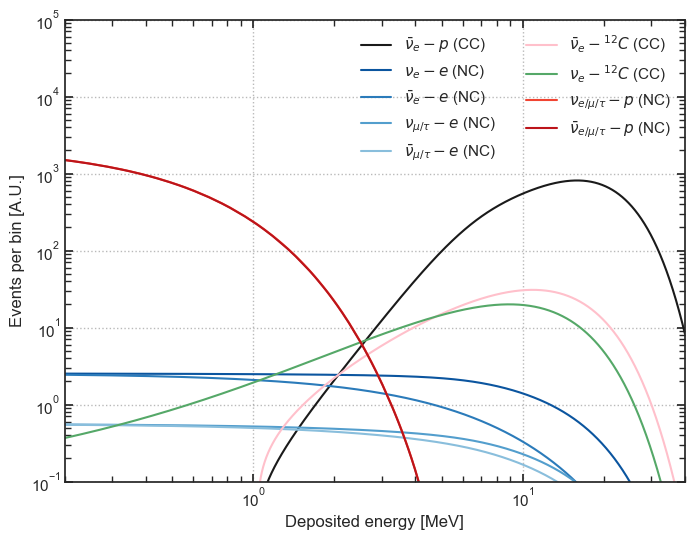

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

ax.grid(ls = ':', c = 'k', alpha = 0.3)

for el in data:
    ax.plot(data_rec[el].E, data_rec[el].counts, label = el, c = color[el])

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(ncols = 2, frameon = False)

ax.set_xlim(0.2, 40)
ax.set_ylim(0.1, 1e5)

ax.set_xlabel('Deposited energy [MeV]')
ax.set_ylabel('Events per bin [A.U.]');